In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
from itertools import product
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor



In [3]:

def calculate_metrics(y_true, y_pred, training_time):
    """평가 지표 계산 함수"""
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'Training_Time': training_time
    }

def train_evaluate_lgbm(data, target_col='avgPrice', time_series=True):
   """LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

   X = data.drop(['date', 'item', target_col], axis=1)
   y = data[target_col]

   lgbm_params = {
       'n_estimators': [500, 1000],
       'max_depth': [10, 20],
       'learning_rate': [0.01, 0.05],
       'num_leaves': [31, 64],
       'min_child_samples': [20, 50],
       'subsample': [0.8, 0.9],
       'colsample_bytree': [0.8, 0.9, 1.0],
       'random_state': [1030],
       'n_jobs': [-1]
   }

   if time_series:
       train_size = len(X)//2
       test_size = len(X)//10
       cv = TimeSeriesSplit(n_splits=5, test_size=test_size, gap=0)
   else:
       cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

   lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
   grid_search = GridSearchCV(
       lgbm, lgbm_params,
       cv=cv,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       verbose=1
   )

   grid_search.fit(X, y)

   print("\n** Model Performance **")
   print(f"Best RMSE: {-grid_search.best_score_:.4f}")
   print("\nBest Parameters:")
   for param, value in grid_search.best_params_.items():
       print(f"{param}: {value}")

   y_pred = grid_search.predict(X)
   plt.figure(figsize=(15, 7))
   plt.plot(data['date'], y, label='Actual', color='blue')
   plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
   plt.title('Actual vs Predicted Price')
   plt.xlabel('Date')
   plt.ylabel('Price')
   plt.legend()
   plt.grid(True)
   plt.xticks(rotation=45)
   plt.tight_layout()
   plt.show()

   metrics = calculate_metrics(y, y_pred, 0)
   print("\nFinal Metrics:")
   for k, v in metrics.items():
       if k != 'Training_Time':
           print(f"{k}: {v:.4f}")

   return grid_search.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5137
[LightGBM] [Info] Number of data points in the train set: 5857, number of used features: 32
[LightGBM] [Info] Start training from score 33360.954414

** Model Performance **
Best RMSE: 899.4076

Best Parameters:
colsample_bytree: 1.0
learning_rate: 0.01
max_depth: 20
min_child_samples: 50
n_estimators: 500
n_jobs: -1
num_leaves: 31
random_state: 1030
subsample: 0.8


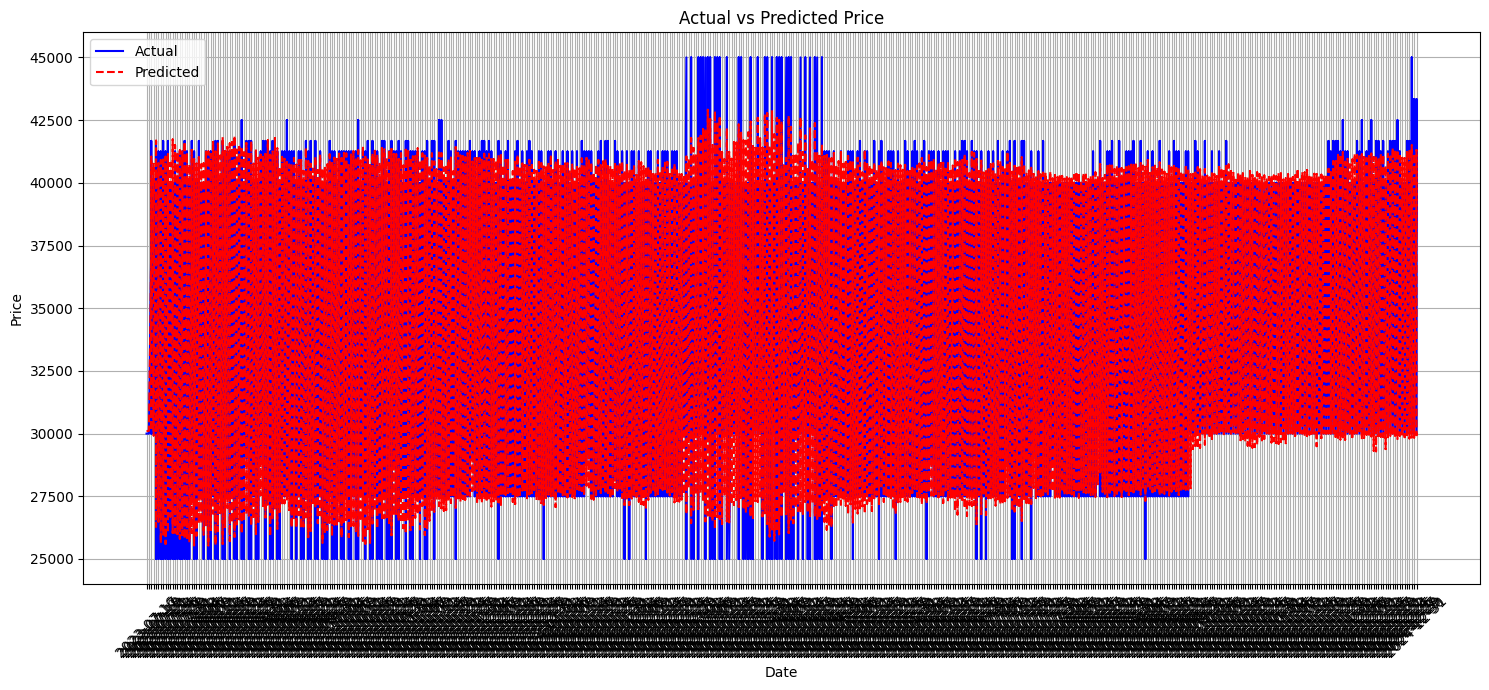


Final Metrics:
MAE: 407.3998
MSE: 623023.7681
RMSE: 789.3185
R2: 0.9589
RMSLE: 0.0239
MAPE: 1.2323


LGBMRegressor(learning_rate=0.01, max_depth=20, min_child_samples=50,
              n_estimators=500, n_jobs=-1, random_state=1030, subsample=0.8)

In [4]:
data = pd.read_csv('../../../data/features/final_oneHot/우럭_price_features_notnull.csv')
train_evaluate_lgbm(data, target_col='avgPrice', time_series=True)